In [1]:
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
style.use('ggplot')

In [2]:
class Support_Vector_Machine:
    def __init__(self, visualization=True):
        self.visualization = visualization
        self.colors = {1:'r', -1:'b'}
        if self.visualization == True:
            self.fig = plt.figure() # initialize a plot
            self.ax = self.fig.add_subplot(1,1,1) #1x1x1 grid subplot
            
    # this is the training method - this method will try to find a decision boundary between our classes by
    # maximizing distance of the decision boundary to each support vector (maximize the width)
    
    # width = (X+ - X-)* (w / ||w||)     <- maximimze width
    # where 
    #      yi(Xi * w + b) - 1 =0         for i: (+,-)
    #
    #      w is the perpendicular vector to the decision boundary
    #      b is bias
    #      Xi is a vector from the origin to each datapoint feature (if i is +, this point lies above
    #         the decision boundary, we classify as +)
    #      yi: +1 (for i +), -1 (for i -)
    #      
    # width equation maximization = minimization of ||w|| (denominator), maximization of b
    # -> this turns out to be a convex optimization problem (quadratic)
    
    def fit(self, data):
        self.data = data
        
        # { ||w|| : [w,b] } - possible combinations of w and b where we want to find a corresponding minimum magnitude w
        # we will store each magnitude as a key in dictioanry
        opt_dict = {}
        
        # for each vector X, we will dot with a transform vector (of which magnitude of each is the same, but
        # direction and dotting with X will be significantly different) at EACH step -> this covers all our
        # vector cases for one magnitude of w
        
        transforms = [[1,1],
                      [-1,1],
                      [-1,-1],
                      [1,-1]]
        
        all_data = []
        
        for yi in self.data: # each key in our data_dict (either +1 or -1 classified)
            for feature_set in self.data[yi]: # each array stored for classifier
                for feature in feature_set: # for each data point in the array
                    all_data.append(feature) # appended into empty list: all_data => [x1,y1,x2,y2,...]
                    
        self.max_feature_value = max(all_data) 
        self.min_feature_value = min(all_data)
        
        all_data = None
        
        # support recall that vectors yi(xi * w + b) ~ 1 will give us an optimal value for all X+ and X-
        
        # using biggest element, we want to step by % of this down and use this to find a minimum w
        
        step_sizes = [self.max_feature_value * 0.1, # big steps
                     self.max_feature_value * 0.01, # if we pass the global minimum of w, we take smaller steps backwards
                     self.max_feature_value * 0.001] # gets expensive to run from this point onwards
        
        # steps for b -> we are using larger steps for b as it does not need to be as precise
        b_range_multiple = 5
        b_multiple = 5
        
        latest_optimum = self.max_feature_value * 10
        
        for step in step_sizes:
            w = np.array([latest_optimum,latest_optimum])
            optimized = False # stay false until we have no more steps to take - we need convexity for this
            
            while not optimized:
                # arange is basically range - but allows you to take steps, here we take step * b_multiple each time
                # numpy.arange([start, ], stop, [step, ], dtype=None)
                
                # we will iterate through possible b values by constant steps - b does not have to be that precise
                
                for b in np.arange(-1 * (self.max_feature_value * b_range_multiple),
                                  (self.max_feature_value * b_range_multiple),
                                  step * b_multiple):
                    for transformation in transforms:
                        w_t = w * transformation
                        found_option = True
                        # weakest link in svm fundamentally, because it needs to run this
                        # calculation on every set of data - SMO attempts to fix this
                        
                        # here we are iterating through each possible transformation of w and testing it
                        # against our constraint requirements (as above, transforms of w may retain magnitude
                        # but have undesirable direction, we will toss these to narrow down our minimum mag)
                        
                        for i in self.data:
                            for xi in self.data[i]:
                                yi = i
                                # constraint function is yi(xi*w + b) >= 1, this must be met 
                                if not yi*(np.dot(w_t, xi) + b) >= 1:
                                    found_option = False
                                    #print(xi,':',yi*(np.dot(w_t,xi)+b))
                                    break
                                    # basically we assume that the dot product of sample X with w is valid
                                    # then we test the sample against our constraint, if it fails, then
                                    # we discard immediately
                        
                        if found_option:
                            opt_dict[np.linalg.norm(w_t)] = [w_t, b] # magnitude of vector as key, [w,b]
                                                                    # as value in dictionary
                
                # after we test every combination of b and transformation of w
                if w[0] < 0:
                    optimized = True
                    print('Optimized a step.')
                else:
                    w = w - step
                    
                # recall that w = np.array([latest_optimum,latest_optimum])
                # we change the variable w until we have found an optimum w
            
            norms = sorted([n for n in opt_dict]) # from lowest to highest of our w magnitudes (keys in opt_dict)
                                                  #           
            
            # recall that opt_dict => { ||w|| : [w,b] } 
            opt_choice = opt_dict[norms[0]] # smallest norm - we have found this to be optimal value of w!!!
            
            self.w = opt_choice[0] # index 0 of [w,b] -> w
            self.b = opt_choice[1] # index 1 of [w,b] -> b
            latest_optimum = opt_choice[0][0] + step * 2 
                    

    # this is the prediction method
    
    def predict(self, features):
        # we're making a classification based on the sign(x*w + b), where * is dot product
        classification = np.sign(np.dot(np.array(features), self.w) + self.b)
        
        # if there is a definite classification (either +, -), and we've picked self.visualization as true
        if classification != 0 and self.visualization:
            self.ax.scatter(features[0], features[1], s=200, marker='*', c=self.colors[classification])
            # this puts a * on the graph for each prediction
        else:
            print('featureset ', features, ' is on the decision boundary')
            
        return classification
    
    def visualize(self):
        # plot all points in our data_dict dictionary on graph - entire function just graphs all points, & hyperplanes
        [[self.ax.scatter(x[0], x[1], s=100, color=self.colors[i]) for x in data_dict[i]] for i in data_dict]
        
        # hyperplane = x * w + b
        # this function:
        # v = x * w + b
        # where v for each below:
        #      psv = 1
        #      nsv = -1
        #      dec = 0
        # for positive support vector, negative support vector and decision boundary in that order
        
        def hyperplane(x,w,b,v):
            return (-w[0]*x - b + v) / w[1] # <= v = x * w + b
        
        datarange = (self.min_feature_value*0.9, self.max_feature_value*1.1) 
        hyp_x_min = datarange[0]
        hyp_x_max = datarange[1]
        
        # (w*x + b) = 1 is the equation of the positive sv hyperplane
        
        psv1 = hyperplane(hyp_x_min, self.w, self.b, 1)
        psv2 = hyperplane(hyp_x_max, self.w, self.b, 1)
        self.ax.plot([hyp_x_min, hyp_x_max],[psv1, psv2], 'k')
        
        # (w*x + b) = -1 is the equation of the negative sv hyperplane
        
        nsv1 = hyperplane(hyp_x_min, self.w, self.b, -1)
        nsv2 = hyperplane(hyp_x_max, self.w, self.b, -1)
        self.ax.plot([hyp_x_min, hyp_x_max],[nsv1, nsv2], 'k')
        
        # (w*x + b) = 0 is the equation of the decision boundary hyperplane
        
        db1 = hyperplane(hyp_x_min, self.w, self.b, 0)
        db2 = hyperplane(hyp_x_max, self.w, self.b, 0)
        self.ax.plot([hyp_x_min, hyp_x_max],[db1, db2], 'g--')
        
        plt.show()
        

Optimized a step.
Optimized a step.
Optimized a step.


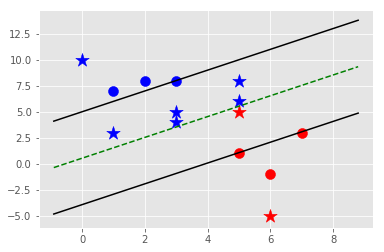

In [3]:
# sample data that we generate to test

data_dict = {-1:np.array([[1,7],
                          [2,8],
                          [3,8],]),
             1:np.array([[5,1],
                        [6,-1],
                        [7,3],])}

# initialize svm as an instance of our svm class above
svm = Support_Vector_Machine()

# fit the sample data_dict
svm.fit(data=data_dict)

# some sample points that we can attempt to predict

predict_us = [[0,10],
              [1,3],
              [3,4],
              [3,5],
              [5,5],
              [5,6],
              [6,-5],
              [5,8]]


for p in predict_us:
    svm.predict(p)
    
svm.visualize()

In [16]:
print(svm.predict([5,2])) # example of a point being classified positive
print(svm.predict([5,10])) # example of a point being classified negative

1.0
-1.0


# Kernelling

In [ ]:
# We will use Kernals to transform linearly inseparable data into a different space

'''Kernal'''
# similarity function that takes two inputs and return a similarity using inner products
# polynomial, gaussian, etc.

'''
Define K(x, x') as a kernal function. Suppose
K(x, x') = z * z'      <- transforms  [x, x'] into some [z, z']

where:
z = function(x)
z = function(x')

Polynomial Kernal:
x = [x1, x2] (feature set) => z = [1, x1, x2, x1^2, x2^2, x1x2]
x' = [x1', x2'] => z = [1, x1', x2', x1'^2, x2'^2, x1'x2']

Thus, if we just try to express using x terms:

    K(xi, xj) = (xi*xj + 1)^d

This is one type of kernal. Another type:

RBF:
K(x, x') = exp(-γ ||x - x'||^2)

'''

# Soft Margin SVM

In [2]:
''' 
Hard Margin SVMs using kernels such as RBF might overfit the data => especially if our support vectors almost perfectly
line up with our feature set

General rule:
# SV's / # samples > 10% might signify overfitment
'''

# We can try a soft margin SVM

'''
Introduce slack variables

yi(xi*w + b) >= 1 - ε

Look at sum of slacks Σ εi. We want as little slack as possible (close to 0), but approaching 0 gives us a hard margin SVM
Recall:

min 1/2||w||^2 + CΣ εi      -> where C is multiplier for 'value' we want slack to affect magnitude of vector w
'''

import numpy as np
from numpy import linalg
import cvxopt
import cvxopt.solvers

     pcost       dcost       gap    pres   dres
 0:  1.5163e+05 -8.7437e+07  2e+08  5e-01  4e-12
 1:  3.9910e+05 -1.6193e+07  3e+07  5e-02  9e-12
 2:  2.5848e+05 -3.2932e+06  4e+06  6e-03  3e-12
 3:  1.9479e+04 -4.3576e+05  5e+05  1e-04  2e-12
 4: -6.3996e+03 -3.9387e+04  3e+04  6e-06  2e-12
 5: -7.6072e+03 -2.4817e+04  2e+04  2e-06  2e-12
 6: -8.4715e+03 -2.5138e+04  2e+04  2e-06  2e-12
 7: -9.1005e+03 -2.4572e+04  2e+04  1e-06  2e-12
 8: -9.1019e+03 -2.3901e+04  1e+04  9e-07  2e-12
 9: -9.7902e+03 -2.0153e+04  1e+04  6e-07  2e-12
10: -9.7727e+03 -1.9881e+04  1e+04  5e-07  2e-12
11: -1.0135e+04 -1.6780e+04  7e+03  2e-07  3e-12
12: -1.0501e+04 -1.6196e+04  6e+03  1e-07  3e-12
13: -1.1084e+04 -1.4255e+04  3e+03  4e-08  3e-12
14: -1.1781e+04 -1.3923e+04  2e+03  5e-09  3e-12
15: -1.1939e+04 -1.3301e+04  1e+03  3e-09  3e-12
16: -1.1947e+04 -1.3298e+04  1e+03  3e-09  3e-12
17: -1.2097e+04 -1.2885e+04  8e+02  1e-09  4e-12
18: -1.2120e+04 -1.2870e+04  7e+02  1e-09  3e-12
19: -1.2070e+04 -1.27

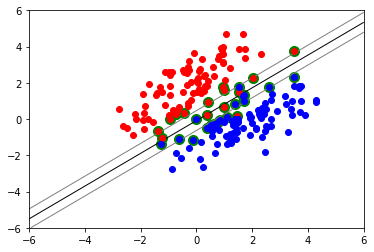

'\nVisualization:\nhttps://www.youtube.com/watch?v=3liCbRZPrZA\n'

In [11]:
# Taken from
# http://www.mblondel.org/journal/2010/09/19/support-vector-machines-in-python/

def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x, y, p=3):
    return (1 + np.dot(x, y)) ** p

def gaussian_kernel(x, y, sigma=5.0):
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

class SVM(object):

    def __init__(self, kernel=linear_kernel, C=None): # if C is none, we are using hard margin SVM
        self.kernel = kernel
        self.C = C
        if self.C is not None: self.C = float(self.C)

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Gram matrix
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])

        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0.0)

        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        a = np.ravel(solution['x']) # alphas

        # Support vectors have non zero lagrange multipliers
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        print("%d support vectors out of %d points" % (len(self.a), n_samples))

        # Intercept - b or bias
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
        self.b /= len(self.a)

        # Weight vector - w
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None

    def project(self, X): # for prediction
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
            return y_predict + self.b

    def predict(self, X):
        return np.sign(self.project(X))

if __name__ == "__main__":
    import pylab as pl

    def gen_lin_separable_data():
        # generate training data in the 2-d case
        mean1 = np.array([0, 2])
        mean2 = np.array([2, 0])
        cov = np.array([[0.8, 0.6], [0.6, 0.8]])
        X1 = np.random.multivariate_normal(mean1, cov, 100)
        y1 = np.ones(len(X1))
        X2 = np.random.multivariate_normal(mean2, cov, 100)
        y2 = np.ones(len(X2)) * -1
        return X1, y1, X2, y2

    def gen_non_lin_separable_data():
        mean1 = [-1, 2]
        mean2 = [1, -1]
        mean3 = [4, -4]
        mean4 = [-4, 4]
        cov = [[1.0,0.8], [0.8, 1.0]]
        X1 = np.random.multivariate_normal(mean1, cov, 50)
        X1 = np.vstack((X1, np.random.multivariate_normal(mean3, cov, 50)))
        y1 = np.ones(len(X1))
        X2 = np.random.multivariate_normal(mean2, cov, 50)
        X2 = np.vstack((X2, np.random.multivariate_normal(mean4, cov, 50)))
        y2 = np.ones(len(X2)) * -1
        return X1, y1, X2, y2

    def gen_lin_separable_overlap_data():
        # generate training data in the 2-d case
        mean1 = np.array([0, 2])
        mean2 = np.array([2, 0])
        cov = np.array([[1.5, 1.0], [1.0, 1.5]])
        X1 = np.random.multivariate_normal(mean1, cov, 100)
        y1 = np.ones(len(X1))
        X2 = np.random.multivariate_normal(mean2, cov, 100)
        y2 = np.ones(len(X2)) * -1
        return X1, y1, X2, y2

    def split_train(X1, y1, X2, y2):
        X1_train = X1[:90]
        y1_train = y1[:90]
        X2_train = X2[:90]
        y2_train = y2[:90]
        X_train = np.vstack((X1_train, X2_train))
        y_train = np.hstack((y1_train, y2_train))
        return X_train, y_train

    def split_test(X1, y1, X2, y2):
        X1_test = X1[90:]
        y1_test = y1[90:]
        X2_test = X2[90:]
        y2_test = y2[90:]
        X_test = np.vstack((X1_test, X2_test))
        y_test = np.hstack((y1_test, y2_test))
        return X_test, y_test

    def plot_margin(X1_train, X2_train, clf):
        def f(x, w, b, c=0):
            # given x, return y such that [x,y] in on the line
            # w.x + b = c
            return (-w[0] * x - b + c) / w[1]

        pl.plot(X1_train[:,0], X1_train[:,1], "ro")
        pl.plot(X2_train[:,0], X2_train[:,1], "bo")
        pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

        # w.x + b = 0
        a0 = -4; a1 = f(a0, clf.w, clf.b)
        b0 = 4; b1 = f(b0, clf.w, clf.b)
        pl.plot([a0,b0], [a1,b1], "k")

        # w.x + b = 1
        a0 = -4; a1 = f(a0, clf.w, clf.b, 1)
        b0 = 4; b1 = f(b0, clf.w, clf.b, 1)
        pl.plot([a0,b0], [a1,b1], "k--")

        # w.x + b = -1
        a0 = -4; a1 = f(a0, clf.w, clf.b, -1)
        b0 = 4; b1 = f(b0, clf.w, clf.b, -1)
        pl.plot([a0,b0], [a1,b1], "k--")

        pl.axis("tight")
        pl.show()

    def plot_contour(X1_train, X2_train, clf): # for contoured kernel
        pl.plot(X1_train[:,0], X1_train[:,1], "ro")
        pl.plot(X2_train[:,0], X2_train[:,1], "bo")
        pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

        X1, X2 = np.meshgrid(np.linspace(-6,6,50), np.linspace(-6,6,50))
        X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
        Z = clf.project(X).reshape(X1.shape)
        pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')

        pl.axis("tight")
        pl.show()

    def test_linear():
        X1, y1, X2, y2 = gen_lin_separable_data()
        X_train, y_train = split_train(X1, y1, X2, y2)
        X_test, y_test = split_test(X1, y1, X2, y2)

        clf = SVM()
        clf.fit(X_train, y_train)

        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        print("%d out of %d predictions correct" % (correct, len(y_predict)))

        plot_margin(X_train[y_train==1], X_train[y_train==-1], clf)

    def test_non_linear():
        X1, y1, X2, y2 = gen_non_lin_separable_data()
        X_train, y_train = split_train(X1, y1, X2, y2)
        X_test, y_test = split_test(X1, y1, X2, y2)

        clf = SVM(polynomial_kernel)
        clf.fit(X_train, y_train)

        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        print("%d out of %d predictions correct" % (correct, len(y_predict)))

        plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)

    def test_soft():
        X1, y1, X2, y2 = gen_lin_separable_overlap_data()
        X_train, y_train = split_train(X1, y1, X2, y2)
        X_test, y_test = split_test(X1, y1, X2, y2)

        clf = SVM(C=1000.1)
        clf.fit(X_train, y_train)

        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        print("%d out of %d predictions correct" % (correct, len(y_predict)))

        plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)

        
    #test_linear()
    #test_non_linear()
    test_soft()

'''
Visualization:
https://www.youtube.com/watch?v=3liCbRZPrZA
'''

# Classifying for more than one

In [ ]:
# We know that SVMs are a binary classifier

# OVR - One vs Rest (default)

'''
The idea here is you separate each group from the rest at the same time.
Do separating hyperplanes for each type of group vs every other group.
We'll have n hyperplanes for n classifiers.
-> this leads to imbalancing (you have one group vs several groups at the same time)
'''

# OVO - One vs One

'''
Create hyperplanes for each group against another group, one at a time.
-> will have much more hyperplanes for more groups
'''

# svm.SVC - https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html